In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

%matplotlib inline

#interactive s
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

In [3]:
#alreayd installed yay!
#!curl -O http://mirrors.ocf.berkeley.edu/apache/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz 
#!tar -xvzf spark-2.4.1-bin-hadoop2.7.tgz 

In [4]:
import os
import findspark
#os.environ["PYSPARK_PYTHON"] = "python3"
findspark.init("C:/spark/spark-2.4.1-bin-hadoop2.7")
#just do exactpath...fuck me

Questions b4 cleaning:
1. What does the data contain?
2. Are the data a census?
3. Does the data form a sample, and if so, is it a probability sample?
4. What limitations does the data have on conclusions?

1. intersection data(to mimic v2v for cars that dont have technology), as well as 20 v2v interactive data
2. Data should be census
3. No
4. How do we know data that is mimicking the v2v device? No crash data so how do we know safety score?

In [5]:
import findspark
from pyspark.sql import SparkSession, Column, Row, functions as F 

In [6]:
spark = (
    SparkSession.builder
        .master("local[*]")
        .appName("LectureExample")
        .getOrCreate()
)
sc = spark.sparkContext
#yay downloaded mah nbo

In [7]:
df = spark.read.format("csv").option("header", "true") \
         .option("mode", "DROPMALFORMED") \
         .load("HACKATHON_DB/Host.csv")

In [ ]:
df.count()

In [10]:
df.limit(10).toPandas()

,Device,Trip,Time,NativeFlag,LocalTimeMS,Latitude,Longitude,Elevation,Heading,GpsSpeed,...,SteerAngle,TurnSignal,Headlamp,Wiper,TransState,StabilityControlStatus,ABSStatus,TracControlStatus,ClosestIntersectId,Distance
0,2004,4,40400,0,77049290,40.282288000000001,-83.531092000000001,288.82001,203.64,27.330667,...,-14.09375,0,0,0,2,0,0,0,0,1746.6903
1,2004,4,40450,0,77049790,40.282175000000002,-83.531152000000006,289.01999,201.42999,27.115862,...,-14,0,0,0,2,0,0,0,0,1760.1263
2,2004,4,40500,0,77050290,40.282060000000001,-83.531205999999997,289.12,199.12,26.887695,...,-13.78125,0,0,0,2,0,0,0,0,1773.4514
3,2004,4,40550,0,77050790,40.281945,-83.531254000000004,289.32001,196.92999,26.648222,...,-13.6875,0,0,0,2,0,0,0,0,1786.6069
4,2004,4,40600,0,77051290,40.281830999999997,-83.531295,289.51999,194.78999,26.349653,...,-13,0,0,0,2,0,0,0,0,1799.6014
5,2004,4,40650,0,77051790,40.281716000000003,-83.531330999999994,289.72,192.92999,26.112749,...,-12.875,0,0,0,2,0,0,0,0,1812.6555
6,2004,4,40700,0,77052290,40.281601000000002,-83.531361000000004,289.82001,190.78999,25.942654,...,-12.78125,0,0,0,2,0,0,0,0,1825.5527
7,2004,4,40750,0,77052790,40.281486000000001,-83.531385,290.12,188.7,25.864542,...,-10.875,0,0,0,2,0,0,0,0,1838.3514
8,2004,4,40800,0,77053290,40.281370000000003,-83.531403999999995,290.32001,186.89,25.782833,...,-11.09375,0,0,0,2,0,0,0,0,1851.1708
9,2004,4,40850,0,77053790,40.281255000000002,-83.531419,290.42001,185.14999,25.720654,...,-11.09375,0,0,0,2,0,0,0,0,1863.9153


In [11]:
def change_dtype(df,column, column_name, predicted_datatype):
    df = df.withColumn(column_name, df[column_name].cast(predicted_datatype))
    return df

In [20]:
df.columns
#extra columns as compared to before are closestintersectionid, and distance..
#normally GPsfixtype...gpsorientsemimaj at end but now its in the middle

['Device',
 'Trip',
 'Time',
 'NativeFlag',
 'LocalTimeMS',
 'Latitude',
 'Longitude',
 'Elevation',
 'Heading',
 'GpsSpeed',
 'GpsFixType',
 'GpsSemiMajAxis',
 'GpsSemiMinAxis',
 'GpsOrientSemiMaj',
 'BrakeStatus',
 'Speed',
 'YawRate',
 'LongAccel',
 'ThrottlePosPct',
 'SteerAngle',
 'TurnSignal',
 'Headlamp',
 'Wiper',
 'TransState',
 'StabilityControlStatus',
 'ABSStatus',
 'TracControlStatus',
 'ClosestIntersectId',
 'Distance']

In [24]:
dtypes = ["int", "int", "int","int","int","double","double","float","float","float",\
         "int","float","float","float", \
         "int","float","float","float","int","float","int", "int", "int","int","int","int", "int", \
         "int","float"]
for index, column in enumerate(df.columns):
    df = change_dtype(df, df[column], column, dtypes[index])

In [33]:
from pyspark.sql.functions import isnan, when, count, col
def one_data_type(df):
    #return nulls for all columns
    return df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])

In [35]:
one_data_type(df).show()
#maybe remove all nulls beforehand so that the nulls over here will just be for datatype errors cuz we will already examine nulls later
#well nvmd it's perfect!

+------+----+----+----------+-----------+--------+---------+---------+-------+--------+----------+--------------+--------------+----------------+-----------+-----+-------+---------+--------------+----------+----------+--------+-----+----------+----------------------+---------+-----------------+------------------+--------+
|Device|Trip|Time|NativeFlag|LocalTimeMS|Latitude|Longitude|Elevation|Heading|GpsSpeed|GpsFixType|GpsSemiMajAxis|GpsSemiMinAxis|GpsOrientSemiMaj|BrakeStatus|Speed|YawRate|LongAccel|ThrottlePosPct|SteerAngle|TurnSignal|Headlamp|Wiper|TransState|StabilityControlStatus|ABSStatus|TracControlStatus|ClosestIntersectId|Distance|
+------+----+----+----------+-----------+--------+---------+---------+-------+--------+----------+--------------+--------------+----------------+-----------+-----+-------+---------+--------------+----------+----------+--------+-----+----------+----------------------+---------+-----------------+------------------+--------+
|     0|   0|   0|         0

*check for wellformed row values*

In [11]:
#trip
df.groupBy(['Trip']).count().toPandas()

,Trip,count
0,296,19150
1,829,329
2,467,6163
3,675,7515
4,691,4774
5,800,1527
6,853,2847
7,451,17164
8,125,14555
9,666,1401


In [13]:
#Time
df.groupBy(['Time']).count().toPandas()

,Time,count
0,45300,2427
1,51550,2569
2,52800,2590
3,83450,2837
4,86900,2797
5,103050,2740
6,108800,2672
7,131450,2431
8,141950,2222
9,35350,1883


In [12]:
#NativeFlag
df.groupBy(['NativeFlag']).count().toPandas()

,NativeFlag,count
0,0,9090299
1,1,2328195


In [ ]:
#LocalTimeMs
df.groupby(["LocalTimeMS"]).count().toPandas()

In [ ]:
#Latitude

In [ ]:
#Longitude

*remove nulls*

#we already checked earlier so we good/removed with dropmalformed option

# rvbsm

In [40]:
rv = pd.read_csv("HACKATHON_DB/RvBsm.csv")

In [42]:
rv.head()

,Device,Trip,Time,RvDevice,NativeFlag,LocalTimeMS,BsmPsId,BasicVehClass,RvRandomId,Latitude,Longitude,Elevation,Heading,GpsSpeed,BrakeStatus,YawRate,LongAccel
0,2004,12,20450,2494,0,80282393,1,0,1368,40.283614,-83.529785,291.89999,228.71249,25.500000,0,-0.97,0.07
1,2004,12,20500,2494,0,80282893,1,0,1368,40.283537,-83.529898,292.00000,227.95000,25.400002,0,-1.46,0.01
2,2004,12,20550,2494,0,80283393,1,0,1368,40.283458,-83.530009,292.10001,226.95000,25.299999,0,-2.19,0.01
3,2004,12,20600,2494,0,80283893,1,0,1368,40.283377,-83.530117,292.10001,225.50000,25.320000,0,-2.92,0.07
4,2004,12,20650,2494,0,80284393,1,0,1368,40.283294,-83.530222,292.20001,224.08749,25.320000,0,-2.92,0.07


In [60]:
rv["Device"].value_counts()

2496    163733
2936    103839
2858     34516
2584     29705
2720     28451
2999     25483
2533     25326
2588     22014
2348     21988
2107     19784
2218     19609
2494     17634
2804     14840
2147     14360
2941     13758
2527     11480
2004     11223
2969     10382
2627      9461
2017      9273
2008      9146
2559      8627
2331      8507
2233      7567
2998      7443
Name: Device, dtype: int64

In [51]:
rv.dtypes
# already correct dtypes great!

Device             int64
Trip               int64
Time               int64
RvDevice           int64
NativeFlag         int64
LocalTimeMS        int64
BsmPsId            int64
BasicVehClass      int64
RvRandomId         int64
Latitude         float64
Longitude        float64
Elevation        float64
Heading          float64
GpsSpeed         float64
BrakeStatus        int64
YawRate          float64
LongAccel        float64
dtype: object

In [53]:
np.sum(rv.isna())
#no nulls yay!

Device           0
Trip             0
Time             0
RvDevice         0
NativeFlag       0
LocalTimeMS      0
BsmPsId          0
BasicVehClass    0
RvRandomId       0
Latitude         0
Longitude        0
Elevation        0
Heading          0
GpsSpeed         0
BrakeStatus      0
YawRate          0
LongAccel        0
dtype: int64

# evtwarn

In [4]:
evtwarn = pd.read_csv("../../Data/EvtWarn.csv")

In [5]:
evtwarn.head()

,Device,Trip,Time,RvDevice,NativeFlag,LocalTimeMS,PsId,RvBasicVehClass,RvRandomId,AlertLevel,...,RvLatOffset,HvLatitude,HvLongitude,HvHeading,HvElevation,HvSpeed,HvBrakeStatus,HvYawRate,HvLongitudinalAccel,HvTurnSignal
0,2004,12,48150,2494,1,80559500,1,0,1368,2,...,-4.904795,40.258686,-83.463096,110.27,295.51999,31.577778,0,0.24,-0.0836,0
1,2004,12,48250,2494,1,80560500,1,0,1368,2,...,-5.043336,40.258585,-83.462745,110.43,295.42001,31.611113,0,0.24,0.0716,0
2,2004,12,48350,2494,1,80561500,1,0,1368,2,...,-5.195783,40.258485,-83.462393,110.53,295.32001,31.622221,0,0.24,0.2074,0
3,2004,12,48450,2494,1,80562500,1,0,1368,2,...,-5.365892,40.258383,-83.462042,110.57,295.12000,31.561111,0,0.24,0.1686,0
4,2004,54,109450,22081,1,83779400,1,0,0,3,...,0.000000,40.236264,-83.366918,4.32,267.22000,6.277778,0,-0.97,0.8282,0


In [ ]:
#check for malformed row values(in specific alertlevel, eventappid)

In [6]:
def df_interact(df):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + 5, col:col + 6]
    interact(peek, row=(0, len(df), 5), col=(0, len(df.columns) - 6))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))


In [8]:
df_interact(evtwarn)
#event appid seems to be 2,3,8,9,11
#alertlevel seems to just be 2 or 3

interactive(children=(IntSlider(value=0, description='row', max=2461, step=5), IntSlider(value=0, description=…

(2461 rows, 35 columns) total


In [10]:
evtwarn['EventAppId'].value_counts()

11    796
3     521
2     482
12    414
10    152
1      58
0      26
9      12
Name: EventAppId, dtype: int64

In [11]:
evtwarn['AlertLevel'].value_counts()

2    1453
3    1008
Name: AlertLevel, dtype: int64

# EDA

In [ ]:
#try matching one trip in rvbsm to that in host

In [75]:
#try deviceid = 2998, trip 1
rv2998 = rv[rv['Device'] ==2998]
rv2998 = dev2998[dev2998["Trip"]==1]

In [71]:
#check in hosts
hosts2998 = df.filter((df.Device == 2998) & (df.Trip ==1))

In [72]:
hosts2998.count()
#so less counts for host than for bsm which could make sense--ie host may update less regularly than rvbsm...
#reaosn there are overall more value sin host could be just more trips...

4487

In [76]:
rv2998 #yea like 6 signgals per second lol

,Device,Trip,Time,RvDevice,NativeFlag,LocalTimeMS,BsmPsId,BasicVehClass,RvRandomId,Latitude,Longitude,Elevation,Heading,GpsSpeed,BrakeStatus,YawRate,LongAccel
615223,2998,1,50,9808,1,42982824,1,0,0,40.236540,-83.366968,275.0,182.0,0.000000,0,0.0,0.0
615224,2998,1,50,9818,1,42982824,1,0,0,40.236603,-83.366971,275.0,185.0,0.000000,0,0.0,0.0
615225,2998,1,50,9820,1,42982824,1,0,0,40.236691,-83.366933,275.0,190.0,1.940000,0,0.0,0.0
615226,2998,1,50,9829,1,42982824,1,0,0,40.237015,-83.366887,275.0,184.0,4.160000,0,0.0,0.0
615227,2998,1,50,22055,1,42982824,1,0,0,40.236403,-83.367109,275.0,96.0,0.000000,0,0.0,0.0
615228,2998,1,50,22066,1,42982824,1,0,0,40.236414,-83.367250,275.0,93.0,4.160000,0,0.0,0.0
615229,2998,1,100,9808,1,42983324,1,0,0,40.236539,-83.366968,275.0,182.0,0.260000,0,0.0,0.0
615230,2998,1,100,9818,1,42983324,1,0,0,40.236600,-83.366972,275.0,185.0,0.000000,0,0.0,0.0
615231,2998,1,100,9820,1,42983324,1,0,0,40.236687,-83.366937,275.0,198.0,1.940000,0,0.0,0.0
615232,2998,1,100,9829,1,42983324,1,0,0,40.237002,-83.366888,275.0,184.0,3.040000,0,0.0,0.0


In [77]:
host2998 = hosts2998.toPandas()

In [87]:
columns_needed = ["Device_x","Trip_x","Time","RvDevice","LocalTimeMS_x","Latitude_x","Longitude_x",'Latitude_y','Longitude_y']
merged = pd.merge(rv2998, host2998, how = "inner", on = "Time").loc[:,columns_needed]
merged.rename(index = str, columns = {'LocalTimeMS_x':'LocalTimeMS','Latitude_x':'Rv_Latitude', 'Longitude_x':'Rv_Longitude',\
                                     'Latitude_y':'Hv_Latitude', 'Longitude_y':'Hv_Longitude'},inplace = True)

In [88]:
merged

,Device_x,Trip_x,Time,RvDevice,LocalTimeMS,Rv_Latitude,Rv_Longitude,Hv_Latitude,Hv_Longitude
0,2998,1,50,9808,42982824,40.236540,-83.366968,40.236370,-83.365445
1,2998,1,50,9818,42982824,40.236603,-83.366971,40.236370,-83.365445
2,2998,1,50,9820,42982824,40.236691,-83.366933,40.236370,-83.365445
3,2998,1,50,9829,42982824,40.237015,-83.366887,40.236370,-83.365445
4,2998,1,50,22055,42982824,40.236403,-83.367109,40.236370,-83.365445
5,2998,1,50,22066,42982824,40.236414,-83.367250,40.236370,-83.365445
6,2998,1,100,9808,42983324,40.236539,-83.366968,40.236370,-83.365445
7,2998,1,100,9818,42983324,40.236600,-83.366972,40.236370,-83.365445
8,2998,1,100,9820,42983324,40.236687,-83.366937,40.236370,-83.365445
9,2998,1,100,9829,42983324,40.237002,-83.366888,40.236370,-83.365445


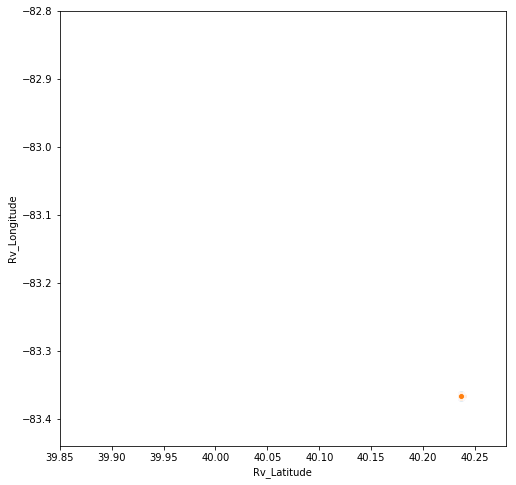

In [103]:
city_long_border = (-83.44, -82.80)
city_lat_border = (39.85, 40.28)

fig,ax = plt.subplots(figsize = (8,8))
sns.scatterplot(x = "Hv_Latitude",y= "Hv_Longitude", data = merged)
ax.set(ylim =city_long_border)
ax.set(xlim = city_lat_border)
sns.scatterplot(x = "Rv_Latitude",y = "Rv_Longitude", data = merged)

## specific for eventappid

In [14]:
ima = evtwarn[evtwarn['EventAppId']==11]

,Device,Trip,Time,RvDevice,NativeFlag,LocalTimeMS,PsId,RvBasicVehClass,RvRandomId,AlertLevel,...,RvLatOffset,HvLatitude,HvLongitude,HvHeading,HvElevation,HvSpeed,HvBrakeStatus,HvYawRate,HvLongitudinalAccel,HvTurnSignal
11,2004,55,11300,10397,1,86353800,1,0,0,2,...,-7.058248,40.236416,-83.366670,274.910000,268.32001,1.580556,1,-0.24,-0.8984,1
12,2004,55,11350,10397,1,86354300,1,0,0,2,...,-6.385495,40.236416,-83.366678,273.940000,268.32001,0.975000,1,0.00,-0.8402,1
13,2004,55,11400,10397,1,86354800,1,0,0,2,...,-6.420202,40.236417,-83.366683,273.940000,268.32001,0.533333,1,0.00,-0.9954,1
14,2004,55,11450,10397,1,86355300,1,0,0,2,...,-6.414733,40.236416,-83.366685,273.940000,268.32001,0.069444,1,-0.24,-0.2194,1
15,2004,55,11500,10397,1,86355800,1,0,0,2,...,-6.362031,40.236416,-83.366685,273.940000,268.32001,0.000000,1,0.00,0.3044,1
16,2004,55,11550,10397,1,86356300,1,0,0,2,...,-6.355458,40.236416,-83.366685,273.940000,268.42001,0.000000,1,0.00,0.2074,1
17,2004,55,11600,10397,1,86356800,1,0,0,2,...,-6.333682,40.236416,-83.366685,273.940000,268.42001,0.000000,1,0.00,0.2074,1
18,2004,55,11650,10397,1,86357300,1,0,0,2,...,-6.334883,40.236416,-83.366685,273.940000,268.42001,0.000000,1,-0.24,0.2074,1
19,2004,55,11700,10397,1,86357800,1,0,0,2,...,-6.348885,40.236416,-83.366685,273.940000,268.42001,0.000000,1,-0.24,0.1686,1
20,2004,55,11750,10397,1,86358300,1,0,0,2,...,-6.334883,40.236416,-83.366685,273.940000,268.42001,0.000000,1,-0.24,0.1686,1
